### Import Libraries

In [1]:
from typing import TypedDict, Annotated, List

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, AnyMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from dotenv import load_dotenv

load_dotenv()

True

### Call LLMs

#### Call LLMs with State

In [29]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [30]:
class State(TypedDict):
    question: str
    response: str

In [31]:
def model(state: State):
    question = state["question"]
    response = llm.invoke([
        SystemMessage("You're a data science specialist"),
        HumanMessage(question)
    ])

    return {"response": response.content}

In [32]:
workflow = StateGraph(State)

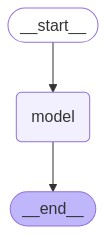

In [33]:
workflow.add_node("model", model)

workflow.add_edge(START, "model")
workflow.add_edge("model", END)

graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [34]:
result = graph.invoke(
    input={
        "question": "What is the Large language models?"
    }, 
)

In [35]:
result

{'question': 'What is the Large language models?',
 'response': 'Large language models (LLMs) are a type of artificial intelligence (AI) that are designed to understand, generate, and manipulate human language. They are built using deep learning techniques, particularly neural networks, and are trained on vast amounts of text data to learn the statistical patterns and structures of language. Here are some key characteristics and components of LLMs:\n\n1. **Architecture**: Most LLMs are based on transformer architecture, which allows them to process and generate text efficiently. Transformers use mechanisms like self-attention to weigh the importance of different words in a sentence, enabling them to capture context and relationships between words effectively.\n\n2. **Training**: LLMs are trained on diverse datasets that include books, articles, websites, and other text sources. This training helps them learn grammar, facts, reasoning abilities, and even some level of common sense knowl

#### Call LLMs with Custom State and Langgraph operator

- In workflows involving messages, a simple `operator.add` doesn’t work well when merging structured messages.
- Instead, LangGraph provides the `add_messages` reducer.

In [36]:
add_messages(
    left = [
        SystemMessage("You're a helpful assistant"),
        HumanMessage("Hi!")
    ],
    right = AIMessage("Hello! How can I assist you today?")
)

[SystemMessage(content="You're a helpful assistant", id='1c3127d5-81dd-4d0a-93d9-00154d823a88'),
 HumanMessage(content='Hi!', id='126e32f0-111b-4d6c-b8aa-50c0b5d19bf2'),
 AIMessage(content='Hello! How can I assist you today?', id='5ad0554f-fd88-4ae2-bb2d-c08bff8f50ef')]

In [37]:
class State(TypedDict):
    messages:Annotated[List[AnyMessage], add_messages]

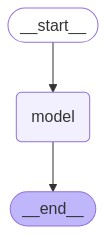

In [38]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

def model(state: State):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": response}

workflow = StateGraph(State)

workflow.add_node("model", model)

workflow.add_edge(START, "model")
workflow.add_edge("model", END)

graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [39]:
result = graph.invoke(
    input={
        "messages": [HumanMessage("What is the Large language models?")]}, 
)

for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================

What is the Large language models?
================================== Ai Message ==================================

Large language models (LLMs) are a type of artificial intelligence (AI) designed to understand, generate, and manipulate human language. They are built using deep learning techniques, particularly neural networks, and are trained on vast amounts of text data from diverse sources, such as books, articles, websites, and more. Here are some key characteristics and features of LLMs:

1. **Scale**: LLMs are characterized by their large number of parameters, often in the billions or even trillions. This scale allows them to capture complex patterns and nuances in language.

2. **Training**: They are typically trained using unsupervised or semi-supervised learning methods, where the model learns to predict the next word in a sentence given the previous words. This process helps the model understan

#### Call LLMs with Langgraph MessagesState

- MessageState simplifies using LangChain messages in workflows without needing custom schemas.｜

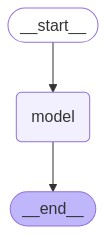

In [40]:
def model(state: MessagesState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": response}

workflow = StateGraph(MessagesState)

workflow.add_node("model", model)

workflow.add_edge(START, "model")
workflow.add_edge("model", END)

graph = workflow.compile()
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [41]:
result = graph.invoke(
    input={
        "messages": [HumanMessage("What is the Large language models?")]}, 
)

for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================

What is the Large language models?
================================== Ai Message ==================================

Large language models (LLMs) are a type of artificial intelligence (AI) designed to understand, generate, and manipulate human language. They are built using deep learning techniques, particularly neural networks, and are trained on vast amounts of text data from diverse sources, such as books, articles, websites, and more. Here are some key characteristics and features of LLMs:

1. **Scale**: LLMs are characterized by their large number of parameters, often in the billions or even trillions. This scale allows them to capture complex patterns and nuances in language.

2. **Training**: They are typically trained using unsupervised or semi-supervised learning methods, where the model learns to predict the next word in a sentence given the previous words. This process helps the model understan

#### Call LLMs with Langgraph MessagesState and Config

In [42]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

MessageState automatically includes a messages list with a reducer.

In [43]:
class State(MessagesState):
    question:str

Checks if a user's name is present in the config.
If so, injects a SystemMessage to personalize the greeting.

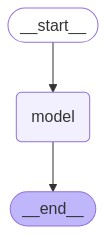

In [44]:
def model(state: State, config: RunnableConfig):
    question = state["question"]
    messages = state["messages"]
    name = None
    if config:
        name = config["configurable"].get("name")

    if name and not messages:
        messages.append(
            SystemMessage(
                "Help the following user. \n"
                f"Name={name} \n"
                "Give an initial greeting before responding."
            )
        )

    messages.append(HumanMessage(question))
    response = llm.invoke(messages)
    messages.append(response)

    return {"messages": messages}

workflow = StateGraph(State)

workflow.add_node("model", model)

workflow.add_edge(START, "model")
workflow.add_edge("model", END)

graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

RunnableConfig is used to inject external parameters during workflow execution.

In [45]:
result = graph.invoke(
    input={"question": "What is the meaning of life?"},
    config={"configurable": {"name": "Tim"}}
)

for message in result['messages']:
    message.pretty_print()

================================ System Message ================================

Help the following user. 
Name=Tim 
Give an initial greeting before responding.
================================ Human Message =================================

What is the meaning of life?
================================== Ai Message ==================================

Hello, Tim! The meaning of life is a profound question that has been explored by philosophers, theologians, and thinkers throughout history. Different cultures and individuals may have varying interpretations. Some find meaning through relationships, love, and connection with others, while others seek purpose through personal achievements, spirituality, or contributing to the greater good. Ultimately, it may be a personal journey for each individual to discover what gives their life meaning. What are your thoughts on it?
